For completeness, we'll be evaluating both our Count Vectorizer & SVC model, as well as our LSTM PyTorch model to get a better understanding of our model's most predictive words and misclassified reviews in the Test Set.

In [96]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer

import captum
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

pd.set_option('display.max_colwidth', None)
%matplotlib inline

In [2]:
reviews_val = pd.read_csv('../data/clean_train_stem.csv')
reviews_val.head(3)

,content,content_stem,score,target
0,"My game was great! I play it on the pc too! But since the recent update, the game does not work on my phone. I have a Samsung s10e. It worked flawlessly before but it keeps getting stuck on the loading screen then crashing. I've cleared the cache, date, and completely reinstalled the game and it DID NOT fix the issue. Please fix soon! I'm missing out on daily quests due to not always being home on my computer, but I always have my phone with me.",pc sinc recent updat work phone samsung e work flawlessli keep get stuck load screen crash clear cach date complet reinstal fix issu pleas fix soon miss daili quest due alway home comput alway phone,3,1
1,This game is awesome but my phone doesn't have much storage to play this game long so lastly I will delete this game soon,awesom phone storag long lastli delet soon,3,1
2,Your game is great I like the way you can tell which region based on buy I don't like how you use a real people and white wash them.,way tell region base buy use real peopl white wash,2,1


### 1.0 LSTM PyTorch

##### 1.1 Load model

In [47]:
# Load the vocab dictionary from the pickle file
with open('../models/pytorch_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [79]:
class SentimentRNN(nn.Module):
    def __init__(self,
            no_layers,
            vocab_size,
            output_dim,
            hidden_dim,
            embedding_dim,
            drop_prob=0.5,
        ):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim, num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        print(batch_size)

        # initialize hidden state
        hidden = self.init_hidden(batch_size)

        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True

        # print(embeds.shape)  # e.g., [50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        # get last batch of labels
        sig_out = sig_out[:, -1]

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        '''
        Initializes hidden state: https://discuss.pytorch.org/t/how-to-handle-last-batch-in-lstm-hidden-state/40858
        '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to('cuda:0')
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to('cuda:0')
        
        hidden = (h0,c0)

        return hidden

In [80]:
model = SentimentRNN(
    no_layers = 2,
    vocab_size = 1502,
    output_dim = 1,
    hidden_dim = 256,
    embedding_dim = 64,
    drop_prob=0.6
)

model.load_state_dict(torch.load('../models/rnn_pytorch_stem_corpus_v20241119.pth'))
model.eval().cuda()

/tmp/ipykernel_1276/1315013514.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/rnn_pytorch_stem_corpus_v20241119.pth'))


SentimentRNN(
  (embedding): Embedding(1502, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [82]:
def predict(text: str, vocab: pickle = vocab, device: str = device) -> int:
    """Function for running inference on PyTorch model."""
    tokens = text.split()
    numerical_tokens = [vocab.get(token, vocab['<unk>']) for token in tokens]
    input_tensor = torch.tensor([numerical_tokens], dtype=torch.long).to(device)

    with torch.no_grad():
        output, _ = model(input_tensor)

        sentiment = torch.round(output.squeeze()).cpu().detach() \
                                                .int().numpy()

    return int(sentiment)

##### 1.2 Most Predictive Words with `captum`

We now create an instance of `LayerIntegratedGradients` using forward function of our model and the embedding layer. This instance of layer integrated gradients will be used to interpret our reviews.

Layer Integrated Gradients will allow us to assign an attribution score to each word/token embedding tensor in the movie review text. We will ultimately sum the attribution scores across all embedding dimensions for each word/token in order to attain a word/token level attribution score.

In [95]:
lig = LayerIntegratedGradients(model, model.embedding)

### 2.0 Count Vectorizer & SVC

##### 2.1 Load model & visualization function

In [ ]:
# Load SVC model
with open('../models/svc_stem_v20241117.pkl', 'rb') as file:
    svc_model = pickle.load(file)

In [ ]:
def barplot_tvec(df, pred, title, color):
    """
    Plot a barplot of the top 20 most frequently occuring words in misclassified reviews (for classical machine learning).
    """
    words_series = df[(df['correctly_classified']==0) & (df['pred']==pred)]['content_stem']
    
    # Instantiate TF-IDF Vectorizer 
    tvec = TfidfVectorizer(stop_words='english')
    
    # Save the tokens in a dataframe
    tvec_df = pd.DataFrame(tvec.fit_transform(words_series).todense(), columns=tvec.get_feature_names_out())
    sum_words = tvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    top_words = sum_words.sort_values(ascending=False).head(10)
    top_words.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    
    # Chart aesthetics
    plt.title(title, size=15, weight='bold')
    plt.xlabel('Count', size=12)
    plt.xlim(0,30)
    plt.yticks(size=12)
    plt.tight_layout()

##### 2.2 Most Predictive Words

Given that the SVC is non-parametric, we are **unable to directly interpret the model's coefficient**. Nonetheless, we can tell that there are certain words that are closely related to the positive or negative sentiment in our corpus.

In [4]:
# Save the words obtained from Count vectorizer in a dataframe
feature_names = svc_model.best_estimator_.named_steps['cvec'].get_feature_names_out()

The output we’re seeing is a sparse matrix, specifically a `scipy.sparse` matrix, which is a compact representation of data where most of the values are zero. This often occurs when working with high-dimensional data such as text vectors (e.g., from TF-IDF or CountVectorizer). The matrix stores non-zero coefficients with their indices.

In [5]:
print(svc_model.best_estimator_.named_steps['svc'].coef_)

  (0, 353)	0.7708889970649196
  (0, 236)	0.14986623074722732
  (0, 373)	0.24561048894691168
  (0, 150)	0.03989245389852954
  (0, 449)	0.27176985816040633
  (0, 217)	-0.02948656353593951
  (0, 380)	0.554799590805861
  (0, 494)	0.7570261974474993
  (0, 424)	0.5046593466015418
  (0, 128)	0.09999999999999987
  (0, 46)	0.3750428085383164
  (0, 475)	0.15644621410554788
  (0, 107)	0.048746102361506546
  (0, 478)	0.21855146767502853
  (0, 77)	0.3807904952603185
  (0, 368)	0.7493480290479122
  (0, 168)	0.4364415072502167
  (0, 35)	0.14568822068289172
  (0, 477)	0.47727163349114266
  (0, 37)	0.3512166650288999
  (0, 395)	0.13921313899369397
  (0, 221)	0.044225935396809246
  (0, 462)	0.6370693071835961
  (0, 23)	-0.2795834196716333
  (0, 53)	0.4044469552757075
  :	:
  (0, 89)	0.5253309399309949
  (0, 82)	0.16591852603511562
  (0, 81)	0.28254499091015944
  (0, 45)	-0.2774841297584302
  (0, 42)	-0.002227378621652218
  (0, 18)	-0.3590514415951366
  (0, 493)	0.44340950389208256
  (0, 456)	0.168219127

To work with these coefficients and turn them into a pandas DataFrame or Series, we'll first need to **convert the sparse matrix into a dense format** or extract its components.

In [6]:
sparse_coef = svc_model.best_estimator_.named_steps['svc'].coef_

# Convert sparse matrix to dense format
dense_coef = sparse_coef.toarray()

In [7]:
# Convert to a DataFrame
svc_coef = pd.DataFrame({'word': feature_names, 'feature_importance': dense_coef[0]})
svc_coef

,word,feature_importance
0,abl,0.098005
1,absolut,-0.062020
2,abyss,0.362198
3,account,0.235481
4,act,0.194492
...,...,...
495,worth,-0.188087
496,wrong,0.171839
497,wuther,0.211337
498,wuther wave,0.111337


In [8]:
# Top words related to positive sentiment (class 0)
pos_sent_svc = svc_coef.sort_values(by='feature_importance').head(10)

In [9]:
# Top words related to negative sentiment (class 1)
neg_sent_svc = svc_coef.sort_values(by='feature_importance').tail(10)

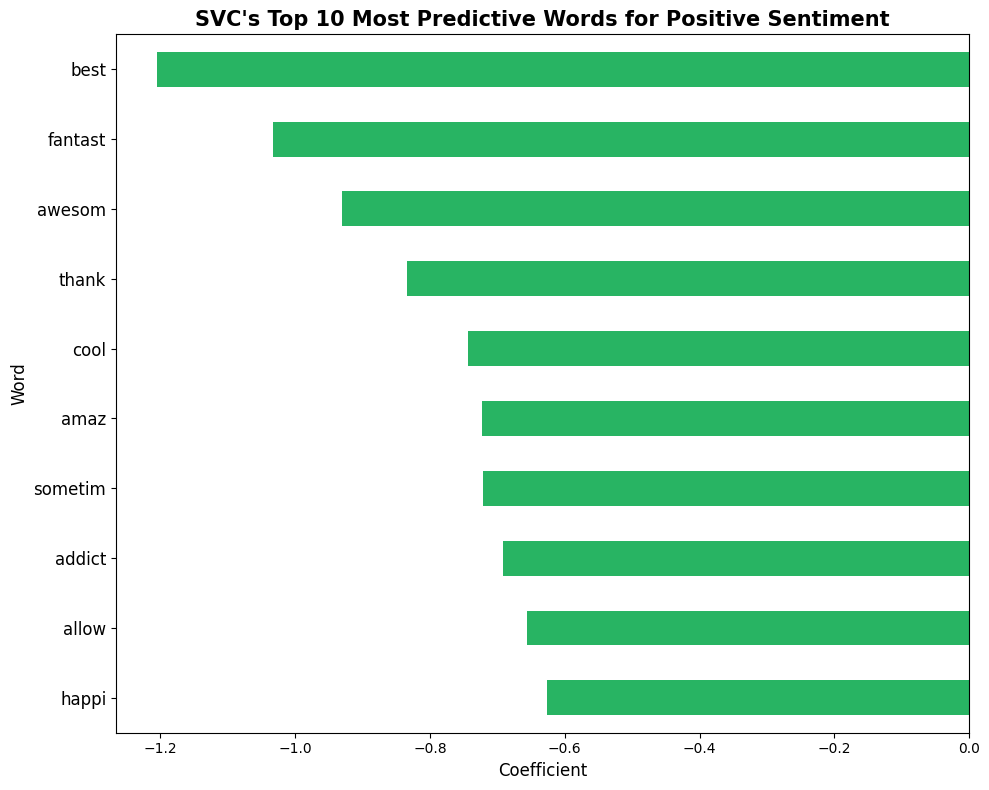

In [97]:
pos_sent_svc.sort_values('feature_importance', ascending=False).plot(x='word', y='feature_importance', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("SVC's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

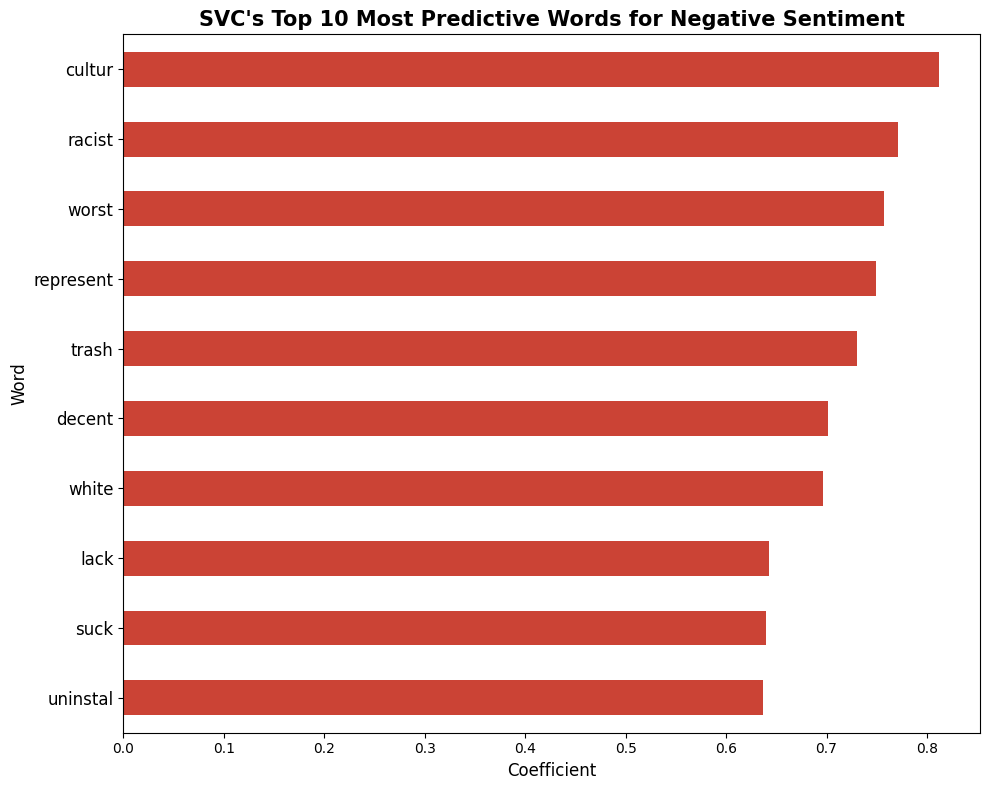

In [98]:
neg_sent_svc.plot(x='word', y='feature_importance', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("SVC's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

Thus, SVC indicates that the words 'fantast', 'addict' and 'happi' are related to positive sentiments. On the other hand, words like 'uninstal', 'suck' and 'worst' are closely associated to negative reviews.

Very interestingly, a lot of words related to ethnicity/race e.g., 'white', 'racist', 'represent' and 'cultur'. Much like our analysis in our [exploratory data analysis](https://github.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker/blob/master/notebooks/02_eda_and_preprocessing.ipynb), these set of complaints likely reference the Natlan update (the most recently released region as of 3rd November 2024). While drawing inspiration from Mesoamerican cultures and Native American cultures, the majority of characters are rather light-skinned contrary to their real life origins. Thus, this is something Hoyoverse should keep in mind when releasing new characters.

##### 2.3 Misclassified Reviews on Test Set

Let's have a look at the misclassified reviews to understand the limitations in our SVC model.

In [10]:
# create a copy of the `reviews_val` dataframe to not alter the original one.
reviews_val_svc = reviews_val.copy()

In [11]:
reviews_val_svc.shape

(6472, 4)

In [12]:
# run inference
reviews_val_svc['pred'] = reviews_val_svc['content_stem'].map(lambda x: svc_model.predict([x])[0])

In [13]:
reviews_val_svc.head(3)

,content,content_stem,score,target,pred
0,"My game was great! I play it on the pc too! But since the recent update, the game does not work on my phone. I have a Samsung s10e. It worked flawlessly before but it keeps getting stuck on the loading screen then crashing. I've cleared the cache, date, and completely reinstalled the game and it DID NOT fix the issue. Please fix soon! I'm missing out on daily quests due to not always being home on my computer, but I always have my phone with me.",pc sinc recent updat work phone samsung e work flawlessli keep get stuck load screen crash clear cach date complet reinstal fix issu pleas fix soon miss daili quest due alway home comput alway phone,3,1,1
1,This game is awesome but my phone doesn't have much storage to play this game long so lastly I will delete this game soon,awesom phone storag long lastli delet soon,3,1,0
2,Your game is great I like the way you can tell which region based on buy I don't like how you use a real people and white wash them.,way tell region base buy use real peopl white wash,2,1,1


In [14]:
# Create a column to indicate if the review was correctly predicted
reviews_val_svc['correctly_classified'] = (reviews_val_svc['pred'] == reviews_val_svc['target'])

In [15]:
# 1369 misclassified reviews
reviews_val_svc[reviews_val_svc['correctly_classified']==0].shape

(1369, 6)

In [18]:
# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
reviews_val_svc[(reviews_val_svc['target']==0) & (reviews_val_svc['pred']==1)][['content','content_stem','score','target','pred']].head(20)

,content,content_stem,score,target,pred
7,"Surprisingly charming so far, and the combat feels natural. Would give it a higher rating, but the Android app has an audio bug - crackling begins after 15+ minutes of play, and gets gradually worse. Restarting the app fixes the issue for the next 15 minutes. I look forward to trying it on PC!",surprisingli charm far combat feel natur would give higher rate android app audio bug crackl begin minut get gradual wors restart app fix issu next minut look forward tri pc,4,0,1
23,"This game is great, don't get me wrong- but the developers are not it. Learn to actually compensate your players, and maybe actually listen to them. New artifacts loadouts? No one asked for the system you've decided to implement, as it's just a fast equip feature with extra steps, rather than an actual ""loadout"".",get wrong develop learn actual compens player mayb actual listen new artifact loadout one ask system decid implement fast equip featur extra step rather actual loadout,5,0,1
50,"I am only a rank 8 adventurer on mobile, but.. Positive: nothing hinders your exploration, except stimina deletion on climb/swim. Doable. Smooth combat, No pay to play elements slow you from playing as long as you want, no tiny backpacks, quality voice acting, this is fun and gorgeous. Negative: only on mobile, the free ranged camera makes it hard to judge combat positioning for male protag. + Yes, there is auto lock on at the general direction you are facing.",rank adventur mobil posit noth hinder explor except stimina delet climb swim doabl smooth combat pay element slow long tini backpack qualiti voic act gorgeou neg mobil free rang camera make hard judg combat posit male protag ye auto lock gener direct face,4,0,1
52,"The game is very good and all but there's one problem with the new character, Mualani, whenever I'd jump a small height like bounce on the mushrooms on sumeru, she'd take lot of damage only by jumping on them.",one problem new mualani whenev jump small height bounc mushroom sumeru damag jump,4,0,1
53,"Since the Natlan update I've been totally back in my Genshin phase, it offers fun game mechanics and good rewards, the only reason I'm giving it 4 stars is because I feel like even tho they added the Imaginary theater the game still lacks a bit of endgame-content. Especially after changing the abyss reset to 1 month, I finish all the floor in less than a day and then have to wait again for a month.. I think just reverting it back to how it's used to be would be a good move",sinc natlan updat total back phase offer mechan reward reason give star tho ad imaginari theater lack bit endgam content especi chang abyss reset month finish floor less day wait month think revert back use would move,4,0,1
54,"My phone can't handle natlan,however this game will still be peak!",phone handl natlan howev peak,4,0,1
72,Best Open World Gacha I've played and HoYo has it mapped out for several more years. Major updates every 6 weeks. Poor reviews are mostly storage space (get a phone from this decade) or salty gamblers (GI has a great Pity system.) if you think you've explored an area 100% there's still dozens of hidden chests and quests and the map is HUGE and still growing. The rating went down awhile back due to a nerf - that was reversed. Bunch of children. And the QoL upgrades are A+ each new patch. F2P too.,best open world gacha hoyo map sever year major updat everi week poor review mostli storag space get phone decad salti gambler gi piti system think explor area dozen hidden chest quest map huge grow rate went awhil back due nerf revers bunch children qol upgrad new patch f p,5,0,1
77,"This is a great game! I love it. I only reccomend to people who play on devices with loads of storage as this game takes up alot of it. (On phone it may overheat, be careful) As a console and mobile player, i have no complaints as graphics are great, characters are great and everything else is excellent. However, a lack of cultural inclusion w

In [19]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
reviews_val_svc[(reviews_val_svc['target']==1) & (reviews_val_svc['pred']==0)][['content','content_stem','score','target','pred']].head(20)

,content,content_stem,score,target,pred
1,This game is awesome but my phone doesn't have much storage to play this game long so lastly I will delete this game soon,awesom phone storag long lastli delet soon,3,1,0
22,"There's a lot of quality of life changes that should be made. 5 Weekly bosses that have resin cost is pretty weak as well. Advancing in Adventure Rank is pretty inconsequential as well beyond a certain point. The 1 year if it was a standard banner character, or weapon choice for everyone beyond AR 15-20 or something would've been amazing and wouldn't have resulted in going from a 4.5 star game down to 2 stars now. The new anniversary rewards are a nice start.",qualiti life chang made weekli boss resin cost pretti weak well advanc adventur rank pretti inconsequenti well beyond certain point year standard banner weapon choic everyon beyond ar someth would amaz result go star star new anniversari reward nice start,2,1,0
28,"Although I didn't make it too far into the game, the graphics are amazing. Sadly, my phone isn't exactly compatible for the amount of storage it takes up and even when I had the space, it took about an hour to load. I hoping that it would be a one time thing but I guess not. Overall, if you have a compatible device I would most definently recommend.",although far graphic amaz sadli phone exactli compat amount storag take space took hour load hope would one time thing guess overal compat devic would defin recommend,3,1,0
37,The unexpected storyline was amazing can't wait to see more and this game have been very kind to me for giving out lots of 5* character<3 Edited: Skip button please.,unexpect storylin amaz wait see kind give lot edit skip button pleas,3,1,0
43,"Genshin is a love-hate relationship. The graphics, mechanics, and general story lines are lovely, as are the special events. However, the reward structure in terms of in-game currency makes it the most expensive gotcha-game on the market. I've played amazing games I don't live up to all again impact can offer but they were far better at rewarding its player base, especially those who pay for in game currency. I play this mainly on PS5 and will be taking a long break to explore other games.",hate relationship graphic mechan gener line love special event howev reward structur term currenc make expens gotcha market amaz game live impact offer far better reward base especi pay currenc mainli ps take long break explor game,3,1,0
63,"GRAPHICS ISSUES AT OPPO RENO 3 MOBILE. All I see is glowing road and not properly rendered gameplay even I'm running at lowest graphic option still buggy in graphics, but the game is Good from RPG mechanics, Storyline, Character customization, and Open world map. Just like an AAA Games, but still fix the Graphic issues that is all I have to say. Pls fix this DEVS",graphic issu oppo reno mobil see glow road properli render gameplay run lowest graphic option buggi graphic rpg mechan storylin custom open world map aaa game fix graphic issu say pl fix dev,2,1,0
69,"An amazing game but gives too little rewards, there's been massive bugs in the game which ruined my world and others and they're won't even give anyone a free 1 pull for the bug",amaz give littl reward massiv bug ruin world other give anyon free pull bug,2,1,0
79,"a real review this time. im giving it 3 stars because the game is fantastic, but the storage it consumes is unbelievable. i used to play on an iPad 8, 32 gb and was heartbroken when i didnt have enough storage for the 6 gb 2.7 update. i just want you to lower the storage consumption, maybe make it that story and hang out quests are manually downloaded. i hope you do see this.",real review time im give star fantast storag consum unbeliev use ipad gb heartbroken didnt enough storag gb updat lower storag consumpt mayb hang quest manual download hope see,3,1,0
81,it's a good game with nice graphics and good worldly exploration but all the characters are just different shades of white,nice graphic world

Now, that we have looked through samples of the false positives and false negatives. We will identify the top most frequently occuring words to explain the misclassifications.

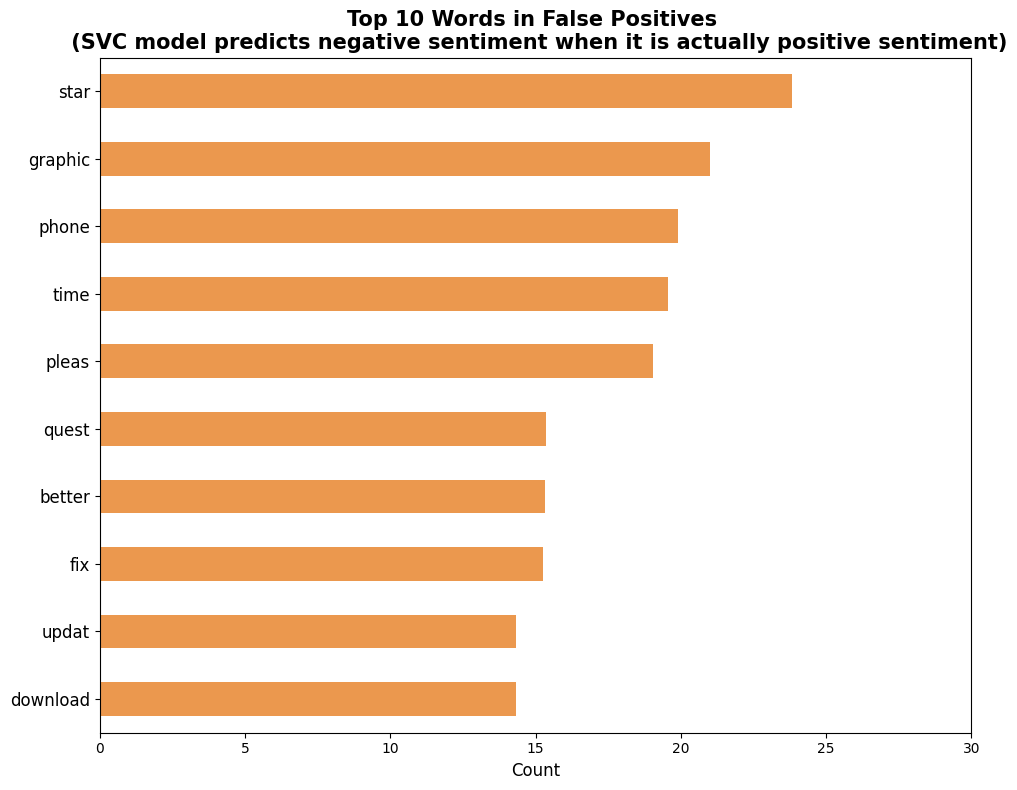

In [28]:
# Top words seen in False Positives - SVC model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(
    df = reviews_val_svc,         
    pred = 1, 
    title = "Top 10 Words in False Positives \n (SVC model predicts negative sentiment when it is actually positive sentiment)", 
    color = '#EB984E',
)

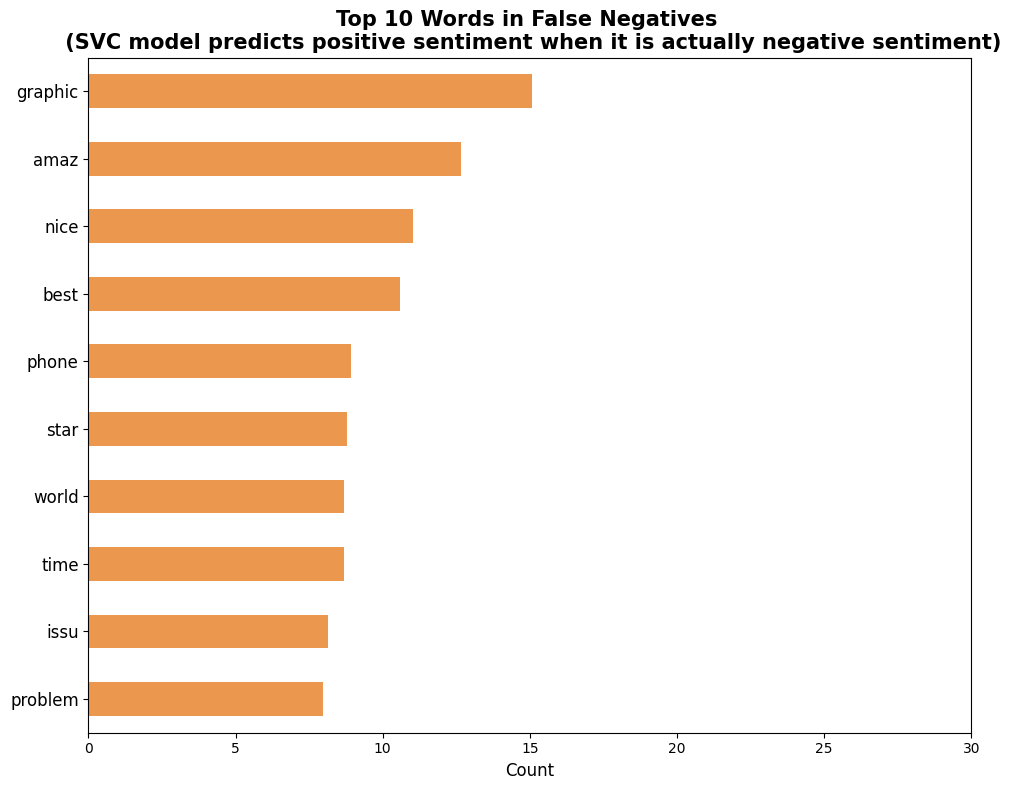

In [29]:
# Top words seen in False Negatives - SVC model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(
    df = reviews_val_svc,
    pred = 0, 
    title = "Top 10 Words in False Negatives \n (SVC model predicts positive sentiment when it is actually negative sentiment)", 
    color = '#EB984E'
)

As observed in the previous section, the word 'amaz' (amazing) and 'best' are highly predictive words associated to positive sentiments. Given that they appear very frequently in false negatives, the model will incorrectly predict these reviews as having a positive sentiment.

Let's now check the scores average scores

In [30]:
# False Negatives
fn = reviews_val_svc[(reviews_val_svc['correctly_classified']==0) & (reviews_val_svc['pred']==0)][['content','content_stem','score']]

In [32]:
# Count the number of times the word 'amaz'/'best' appears in the review
fn['count_amazbest'] = fn['content_stem'].str.count('amaz' or 'best')

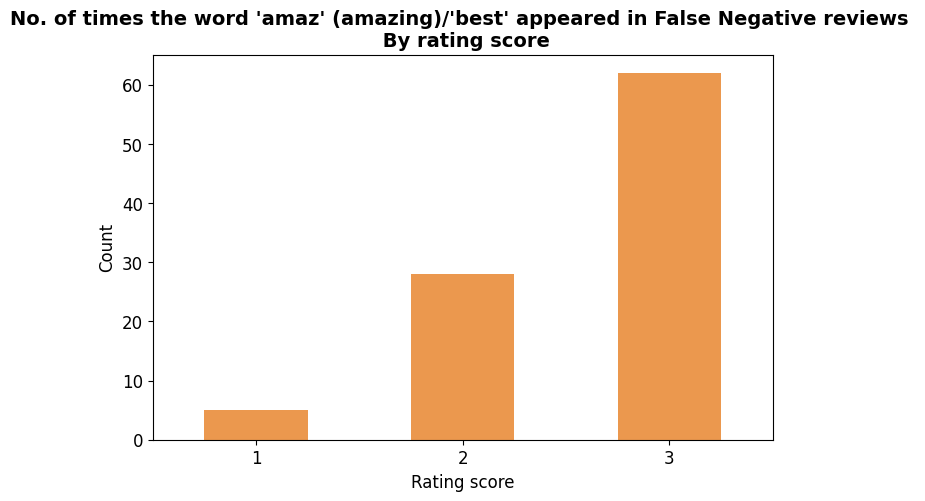

In [35]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'amaz' (amazing)/'best' was seen
fn.groupby('score')['count_amazbest'].sum().plot(kind='bar', color='#EB984E')

plt.title("No. of times the word 'amaz' (amazing)/'best' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

We observe that there are quite a few users who wrote reviews with the word 'amaz' (amazing)/'best' in them, yet gave the app a rating of 3. Since the model has been trained to believe that the word 'amaz' (amazing)/'best' belongs to a positive sentiment, the model has thus predicted these to be positive reviews. Hence, **misclassification in the SVC model happen as a result of fence-sitters writing reviews that have positive connotation.**

In [44]:
# View only the False Negatives that has the words 'amaz' (amazing)/'best' in it
fn[fn['count_amazbest']>0][['content','score']].tail(10)

,content,score
5193,It's an amazing game one of the best I have played so far and trust me I have played a lot of different games and the graphics are amazing but there is just one problem that I think everyone relates to it's the space it takes up on your phone or pc so I have been playing it on my phone and lately with so many new updates it doesn't fit in my phone and I currently don't own a pc and my playstation has other games so I sadly can't play it,3
5722,"I play console but I feel like I'll join in. Being completely fair: the music and gaphics are very nice, all the voice actors did an amazing job. Theres two massive problems with this game though. It takes very long time to get to the point where you can do summons and the rates themselves are extremely low. Obviously, this is a buisness strategy to bleed money from the player base and I simply cannot recommend the game for that reason. Especially don't play if you have a gambling addiction.",2
5759,"Amazing game, amazing visuals, amazing story, amazing everything. Though there are two things that made me give 3 stars. 1. Being that the game is barely optimized for mobile play, if you dont have a middle-high end phone, you'll be watching a slide show, i cant even roam the world without it freezing every second or two, 2. Resin system, for those who doesn't play the game resin is basically energy, and if you're gonna grind this resin will be the thing that will be limiting grinding by alot.",3
5786,"Amazing game, I love the freedom that was allowed throughout the entire world, animations are stunning, but there are several issues, battery was completely drained to the point that my charger couldn't keep up. The game is extremely laggy even on the lowest graphics often triggered by the slightest movement of my screen.",3
5803,"It's amazing, also overheating and lagging my phone, yes I'm using android, too much MB or GB, well its a great game tho, I guess but the characters are very nice and the design are absolutely amazing and creative. but still I couldn't see or the twins optional character thingy or. hear the story of davlin or stormterror, or like that, it's always glitching and cutting off.",3
6016,"Graphics and gameplay-wise? Absolutely amazing and stunning. And its free. But there are big flaws in this game. Though as of this review, it's only been out for less than a month so it could potentially change. Currently, the biggest flaw this game has is its resin system. After AR30, it's a pain to rank up and lvl your characters bc of low resin cap . Decreasing the cost of resin or increasing the cap by AR lvl should help, and world bosses shouldn't cost any since they're timegated anyway.",2
6092,"Amazing game, gripping story, and well written characters with fantastic music as well. The only issue at the moment is that the system requirements which are way too high, given that only a small amount of mobile players actually have premium phones that can run this game smoothly. It's really annoying everytime you get to a Stormterror cutscene or fight, you can't see anything and you'll end up exhausting all your items trying to stay alive but failing anyway. Please optimize your game better.",3
6241,"Amazing Game With Great Graphics and the style of the game is simply amazing. This is an open world game with very versatile combos, and with only 2 map open the map is alrdy boundless this game is practically screaming addicting. But don't get ur hopes too high though. As there's no really perfect game because everyone's expectations are different. Edit: After playing for a while, the game feels really tiring and currencies to get new characters become harder to get because the rewards is lack",3
6325,"Pro: Amazing solo game. Wide world to explore. Tons of activity & quest to chase. Very nice player treatment with events and access to shop & materials. Enemy lv up also, as you lv up, so always a difficult challenge. Heavy grind. Con: Solo game. Anti co-op. The game actu

Thus, misclassification in the context of 'amaz' (amazing)/'best' occurs when:

- User leaves a positive review but gives rates the app 2/3-stars. For example, "It's an amazing open world game with an amazing storyline and great characters love this game a lot ❤️".
These kinds of misclassifications are unavoidable and even a human will interpret it to be positive sentiment.
- User writes a review that mentions Shopee is 'good' in a one aspect, but indicates that there are other areas of improvement e.g., "4 years and you still can't skip the dialogue. Amazing combat and character designs though." Misclassifications of this sort can be reduced if the model was trained on more negative sentiment. Given the limited pool of negative reviews on Google Play, we can look into training the model on negative reviews from other sources e.g., Apple app store, metacritic, etc. in the future.